# Generate the trainning and validation set file 
1. list txt for training and validation
2. h5 file for training and validation
3. txt file refer to h5 file for training and validation

In [1]:
import h5py
import numpy as np
from random import shuffle
import os
os.chdir('../../')
import sys
import time
sys.path.insert(0, './python')
sys.path.append('/local-scratch/xca64/tmp/caffe-master/python/myFunc')
import caffe
import numpy as np
from pylab import *
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import tempfile
from colorConstancy import * 

caffe.set_device(0)
caffe.set_mode_gpu()

In [2]:
def run_solver(solver, niter, disp_interval, test_interval):
    blobs = ('loss', 'acc')
    loss, acc = (np.zeros(niter), np.zeros(niter))
    test_loss = (np.zeros(niter/test_interval)) 
    for it in range(niter):
        solver.step(1)  # run a single SGD step in Caffe
        loss[it] = (solver.net.blobs['loss'].data.copy())
        acc[it] = 0#(solver.net.blobs['loss_ang'].data.copy())
        if it % disp_interval == 0 or it + 1 == niter:
            loss_disp = 'loss: %.3f'%loss[it]
            print '%3d) %s Angular Erro %.3f' % (it, loss_disp, acc[it])     
            #print(solver.net.blobs['fc8_flickr'].data[1], solver.net.blobs['illu'].data[1])
        # if it % test_interval == 0:
        #     print "%3d) test loss is %.3f"% (it ,solver.test_nets[0].blobs['accuracy'].data.copy())
        #     test_loss[it//test_interval] = solver.test_nets[0].blobs['accuracy'].data.copy()
    # Save the learned weights from both nets.
    weight_dir = tempfile.mkdtemp()
    name = 'firstTry'
    weights = {}
    filename = 'weights.%s.caffemodel' % name
    
    weights[name] = os.path.join(weight_dir, filename)
    solver.net.save(weights[name])
    
    return loss, test_loss, acc, weights

#Generate all training and validation files

#Define Training Solver and Run

In [ ]:
#Training Solver
solver = caffe.SGDSolver('models/color_constancy/gehler_482_solver.prototxt')
solver.net.copy_from('models/bvlc_reference_caffenet/bvlc_reference_caffenet.caffemodel')

In [ ]:
niters = 100
loss_1, test_loss, acc_1, weights_1 = run_solver(solver, niters,20, 5000)
solver.net.save('models/color_constancy/result/gehler_482_3000_iters_cross_validation.caffemodel')

#Define Validation Solver and Run

In [20]:
solver = caffe.SGDSolver('models/color_constancy/gehler_482_solver_validation.prototxt')
solver.net.copy_from('models/color_constancy/result/gehler_482_3000_iters_cross_validation.caffemodel')

In [37]:
validationIters = 14 #every time forward a batch size image
validationSetSize = 161 #number of validation images
allAngulareErr = np.array([])
allGroundTruth = np.array([0,0,0])
allImg = np.zeros([1,3,227,227])
for it in range(validationIters):
    solver.net.forward()
    estimatedIllu = solver.net.blobs['fc8_flickr'].data.copy()  #batch size illumination estimation result
    groundtruethIllu = solver.net.blobs['illu'].data.copy()  #batch size illumination estimation result
    #print solver.net.blobs['label'].data.copy() 
    #allGroundTruth = np.vstack((allGroundTruth, estimatedIllu))
    #allImg = np.vstack((allImg, solver.net.blobs['data'].data.copy() ))
    allAngulareErr = np.hstack((allAngulareErr, np.squeeze( multiangle(estimatedIllu, groundtruethIllu))))
    print np.shape(allAngulareErr)
    #allAngulareErr = np.vstack((allAngulareErr, multiangle(estimatedIllu, groundtruethIllu)))

(50,)
(100,)
(150,)
(200,)
(250,)
(300,)
(350,)
(400,)
(450,)
(500,)
(550,)
(600,)
(650,)
(700,)


In [ ]:
for i in range(len(allAngulareErr)):
    for j in range(len(allAngulareErr)):
        if allAngulareErr[i] == allAngulareErr[j] and i != j:
            print i
print "Done"

# Save the result

In [38]:
print np.mean(allAngulareErr)

6.21981103835


#Only for debug

In [19]:
solver.net.forward()

{'loss': array([ 4.67904854], dtype=float32)}

In [17]:
img = solver.net.blobs['data'].data.copy()

In [23]:
allImg = np.zeros([1,3,227,227])

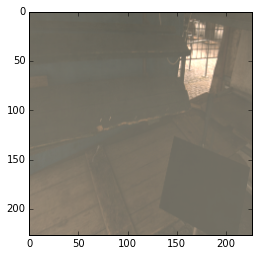

In [35]:
image = allImg[162,...]
plt.imshow(deprocess_net_image(image))

In [29]:
# Helper function for deprocessing preprocessed images, e.g., for display.
def deprocess_net_image(image):
    image = image.copy()              # don't modify destructively
    image = image[::-1]               # BGR -> RGB
    image = image.transpose(1, 2, 0)  # CHW -> HWC
    image += [123, 117, 104]          # (approximately) undo mean subtraction

    # clamp values in [0, 255]
    image[image < 0], image[image > 255] = 0, 255

    # round and cast from float32 to uint8
    image = np.round(image)
    image = np.require(image, dtype=np.uint8)

    return image